# Koopman decomposition, a toy case: Duffing oscillator


The aim of this notebook is to describe the dynamics of a non-linear dynamical system by means of the Koopman theory.

## Introduction

We consider a quantity $x$ (a vector) which evolves with time, following a dynamical system. Think for example of the joint location of the planets in our solar system, which follows the law of gravitation.

Formally, given an initial state $x(t=0) \in \mathbb{R}^n$ at time $t=0$, the time evolution of $x$ is governed by the following dynamical system:
$$
\dot{x(t)} = f(x(t)) \quad \text(1)
$$

where $\dot{x(t)} := {dx}/{dt}$ is the temporal derivative, and $f:\mathbb{R}^n \rightarrow \mathbb{R}^n$ is a given map describing the dynamics.

For a given $f$, it is not always possible to solve the differential equation (1) analytically. For this reason, instead, numerical schemes are usually employed, to integrate in time $t$ (and space $\Omega$ if needed) the eq (1), so as to propagate the initial condition $x(0)$ up to a desired time $T$; think of $x(T) = x(0) + \int_{t=0}^{T} f(x(t)) dt$. The discretization in time of eq (1) or of the integral introduces numerical approximations, and yields estimates of $x(T)$ of various quality depending on the discretization scheme.

In the field of numerical simulations, discretization schemes have been studied for a long time, and numerical solvers already exist to provide good estimates of integrals (far better than with the naive discretization $x_{t+dt} = x_t + dt\,f(x_t)$, which induces a $O(dt^2)$ error at each time step).

The goal of this practical session is to make use of such numerical solvers to improve the learning of dynamical systems with neural networks.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

## Duffing oscillator

As a toy example, we consider the Duffing oscillator, where the state $x = (x_1, x_2) \in \mathbb{R}^2$ follows the dynamical system described by the following ODEs:

$$
\dot{x}_1 = x_2\\
\dot{x}_2 = x_1 - x_1^3
$$

To integrate in time the ODEs, a 4th order Runge-Kutta scheme can be used. 


In [2]:
def duffing(t, x : np.ndarray) -> np.ndarray:
    dx = np.zeros(x.shape)
    dx[0] = x[1]
    dx[1] = x[0] -x[0]**3 
    return dx

In [3]:
tmax = 500    #time-horizon integration
niter = 5000  #number of time steps integration
Ninit = 60    #number of initial conditions

X0 = (np.random.rand(Ninit,2)-0.5)*4
t = np.linspace(0, tmax, niter)
Xt = np.zeros((X0.shape[0],X0.shape[1],niter))
for i in tqdm(range(X0.shape[0])):
    f = solve_ivp(duffing, [0,tmax], X0[i], method='RK45',t_eval=t)
    Xt[i,:] = f.y

100%|██████████| 60/60 [00:14<00:00,  4.14it/s]


The following plot shows trajectories for different initial conditions:

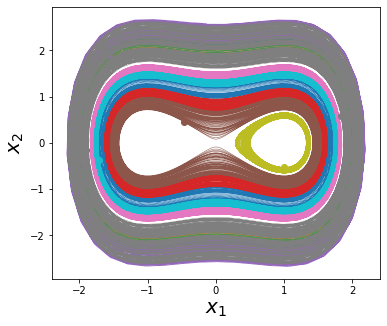

In [4]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(131)
cm = plt.get_cmap("tab10")
print(cm)
for i in range(10):
    ax.plot(Xt[i,0,:], Xt[i,1,:],lw=0.5, color=cm(i))
    ax.plot(Xt[i,0,0], Xt[i,1,0],'o',lw=1.5, color=cm(i)) #initial condition
ax.set_xlabel('$x_1$', fontsize = 20)
ax.set_ylabel('$x_2$', fontsize = 20)
plt.show()

## The Koopman operator
### Discontinuous in time case
Given the discrete non-linear dynamical system

$$
x_{t+1} = \mathbf{F}(x_t)
$$

where $\mathbf{F}$ might be the flow map of the continuous dynamical system in eq (1) and $X = \{x_t | t = 1 \ldots N \}$ the time series of the system state.

$$
\mathbf{F}(x(t_0)) = x(t_0) + \int_{t_0}^{t_0+ t} f(x(\tau))d\tau 
$$

the Koopman theory states that there exists an infinite-dimensional linear operator $\mathcal{K}$ that advances in time all observable functions $g_i: \mathbb{R}^n \rightarrow \mathbb{R}$

$$
\mathcal{K} g_i(x) = g_i \circ \mathbf{F}(x).
$$

This way, the non-linear dynamics of $x$, described by $\mathbf{F}$, can be turned into a **linear** dynamical system, described by $\mathcal{K}$, acting on another representation space, formed by the observable quantities $g_i(x)$.

It is then sufficient to find a function $g: \mathbb{R}^n \rightarrow \mathbb{R}^m$ with $m \gg n$ that embeds the state $x$ into a "larger enough" dimensional space $m$ such that the linear operator $\mathcal{K}$ can be inferred by a matrix $\mathbf{K} \in \mathbb{R}^{m \times m}$.

To project back the dynamics from the Koopman space ($\mathbb{R}^m$, where $g(x)$ lives) to the phase space ($\mathbb{R}^n$, where $x$ lives), a supplementary function $\varphi: \mathbb{R}^m \rightarrow \mathbb{R}^n$ is needed. Going from $x$ to the Koopman space and back yields $\varphi \text{ o  } g = $ Id.

Under this condition, the functions $g$, $\varphi$ and $\mathbf{K}$ can be parametrized $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{K}_{\phi}$, and the parameters $\theta$, $\rho$ and $\phi$ can be learned minimizing suitable loss functions. 

For this purpose, given a time series $X = \{x_t | t = 1 \ldots N \}$, the following conditions hold:


1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x_t)) - x_t  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{K_{\phi}} g_{\theta} ( x_t ) - g_{\theta} (x_{t+1})  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{K_{\phi}} g_{\theta} ( x_t )\right) - x_{t+1} \Vert = 0
     $$

The last three errors can be used as loss functions to train three different neural networks. These different neural networks compose our architecture that can be summarized as in the following sketch:



![architecture](./architecture.png) 

In [5]:
# arrange the dataset
from sklearn.model_selection import train_test_split
X = np.transpose(np.concatenate([Xt[i,:,:-1] for i in range(Xt.shape[0])], axis=1))
Y = np.transpose(np.concatenate([Xt[i,:,1:] for i in range(Xt.shape[0])], axis=1))

X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.2)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(239952, 2) (59988, 2) (239952, 2) (59988, 2)


In [6]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.utils.data import DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')

batch_size = 2000     # data per batch

training_data = TensorDataset(torch.from_numpy(X_train),torch.from_numpy(Y_train))
test_data = TensorDataset(torch.from_numpy(X_test),torch.from_numpy(Y_test))

train_dataloader_discrete = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader_discrete = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# create the models
feature_dim = 2       # dimension of the Duffing oscillator
hidden_layer = 5      # number of hidden layers in g (ENCODER) and \varphi (DECODER) 
output_dim = 30       # dimension in Koopman space

In [7]:
class encoder(nn.Module):
    def __init__(self, layer_dim):
        super(encoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i+1]))
        
    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)
        

In [8]:
class decoder(nn.Module):
    def __init__(self, layer_dim):
        super(decoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1,0,-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i-1]))
        
    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)

In [9]:
class autoencoder(nn.Module):
    def __init__(self,feature_dim, hidden_layer, output_dim):
        super(autoencoder, self).__init__()
        layer_dim = [output_dim if i == hidden_layer else feature_dim+i*(output_dim-feature_dim)//hidden_layer for i in range(hidden_layer+1)]
        self.encoder = encoder(layer_dim)
        self.decoder = decoder(layer_dim)
    def forward(self, X):
        X = self.encoder(X)
        return self.decoder(X)

The Koopman operator $\mathbf{K}$ (which is linear, and thus a matrix) must have a spectral radius $\rho(\mathbf{K})\le 1$. Such condition will provide a stable -or at least a marginally stable- Koopman operator. To fulfill this requirement, we might leverage on the Perron-Frobenius theorem. 

The Perron-Frobenius th. states: if $\mathbf{K}$ is a $m \times m$ positive matrix i.e. $k_{ij} > 0$ for $1 \le i,j \le m$, then the following inequality holds:

$$
\min_i \sum_j k_{ij} \le \rho(\mathbf{K}) \le \max_i \sum_j k_{ij}
$$


**Question 1.** : Complete the `KoopmanModule` class to enforce $\rho(\mathbf{K})\le 1$, making use of the Perron-Frobenius theorem.

In [10]:
class KoopmanModule(nn.Module):
    def __init__(self, output_dim, ortho_init: bool = False):
        super().__init__()
        self.output_dim = output_dim
        
        ## To Be Implemented
        self.layer = nn.Linear(output_dim, output_dim, bias=False)
        if ortho_init:
          # With orthogonal init, all eigenvalues will have modulus exactly
          # equal to 1, so rho(K) = 1
          nn.init.orthogonal_(self.layer.weight)
          self.weight = self.layer.weight # just for code compatibility
        else:
          # Manually enforcing of rho(K) <= 1 using Perron-Frobenius
          # theorem
          self.weight = torch.exp(torch.randn(output_dim, output_dim))       
          weight_row_sum = torch.sum(self.weight, dim=1).repeat(output_dim, 1).T
          self.weight /= weight_row_sum
          
          with torch.no_grad():
              self.layer.weight = torch.nn.Parameter(self.weight)

    def forward(self, X):
        x, y = X.shape
        if y != self.output_dim:
            sys.exit(f'Wrong Input Features. Please use tensor with {self.output_dim} Input Features')
        ## To Be Implemented
        return self.layer(X), self.layer

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
AUTOENCODER = autoencoder(feature_dim, hidden_layer, output_dim).to(device)
KPM = KoopmanModule(output_dim).to(device)
print(AUTOENCODER)

autoencoder(
  (encoder): encoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=2, out_features=7, bias=True)
      (1): Linear(in_features=7, out_features=13, bias=True)
      (2): Linear(in_features=13, out_features=18, bias=True)
      (3): Linear(in_features=18, out_features=24, bias=True)
      (4): Linear(in_features=24, out_features=30, bias=True)
    )
  )
  (decoder): decoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=30, out_features=24, bias=True)
      (1): Linear(in_features=24, out_features=18, bias=True)
      (2): Linear(in_features=18, out_features=13, bias=True)
      (3): Linear(in_features=13, out_features=7, bias=True)
      (4): Linear(in_features=7, out_features=2, bias=True)
    )
  )
)


In [13]:
opt_aut = torch.optim.Adam(AUTOENCODER.parameters(), lr=0.0001)
opt_kpm = torch.optim.Adam(KPM.parameters(), lr=0.00001)

**Question 2.** : Define a function to compute the loss to be minimized. It should at least include the 3 terms listed above:
- Reconstruction error
- Prediction error in the Koopman space
- Prediction error in the phase space

Because the different objectives outlined by these losses may compete, the training can be difficult. You may try different variations on these losses and comment your findings. In order to improve the training process, one can for instance:
- Add a multiplicative factor in front of each loss component, to balance their importance;
- We can refine the loss acting upon the latent space, by using a variational autoencoder approach. This is similar to the Gaussian likelihood used in the first practical (TD1). We want the prediction in the latent space (i.e. the Koopman space) to be a normal distribution $\mathcal{N}(0, 1)$ . Add a corresponding loss for the latent space. Difference to 0 mean and 1 standard deviation must be thus included in the loss;
- Freeze the gradients of one part of the network, for instance the encoder, for one specific objective, using the [`requires_grad`](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) property. For instance:
```python
criterion = nn.MSELoss()
...
# Compute one part loss_l of the total loss
# First deactivate gradient computation for irrelevant parts of the architecture
for p in AUTOENCODER.encoder.parameters():
    p.requires_grad = False
loss_l = criterion(pred, target)
# Restore the gradient computation
for p in AUTOENCODER.encoder.parameters():
    p.requires_grad = True
...
total_loss = loss_1 + ... + loss_l + ...
return total_loss
```

In [14]:
# For this TP, I have decided to look at the effect on freeze the gradients
# of the encoder, and looking at the impact by computing the error in 
# koopman space while freezing these gradients (the same thing could)
# have been done with other errors

# Influence of multiplying factors will be done in Question 7

def LOSS(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred,
         reconstruction_factor = 1.0, koopman_factor = 1.0, phase_factor = 1.0,
         use_divergence_to_normal = False, frozen_encoder = False):
    # To Be Implemented
    criterion = nn.MSELoss()
    reconstruction_error = criterion(X_, X_recon) * reconstruction_factor
    error_phase_space = criterion(Y_, Y_pred) * phase_factor
    if not frozen_encoder:
      error_koopman_space = criterion(gY_pred, gY_) * koopman_factor
      total_loss = reconstruction_error + error_koopman_space + error_phase_space
    else:
      total_loss = reconstruction_error + error_phase_space

    if use_divergence_to_normal:
      mean = torch.mean(gX_, dim=0)
      std = torch.sqrt(torch.mean((gX_ - mean)**2, dim=0))
      total_loss += criterion(mean, torch.zeros(mean.shape, device=device))
      total_loss += criterion(std, torch.ones(mean.shape, device=device))

    return total_loss

The following cell executes the training loop. You can modify it in order to display the different intermediate losses computed in the function `LOSS` above.

In [15]:
use_divergence_to_normal = True

for epoch in range(100):
    AUTOENCODER.train() 
    KPM.train()
    total_train_loss = 0
    total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
    for X_, Y_ in train_dataloader_discrete:
        X_, Y_ = X_.to(device), Y_.to(device)
        
        opt_aut.zero_grad()
        opt_kpm.zero_grad()
        
               
        # gX_ = observable(X_), gY_ = observable(Y_)
        gX_ = AUTOENCODER.encoder(X_)
        gY_ = AUTOENCODER.encoder(Y_)
        
        # X_recon = in_observable(observable(X_))
        X_recon = AUTOENCODER.decoder(gX_) # gX_ ?
         
        # gY_pred = KPM*observable(X_)
        gY_pred, Koop = KPM(gX_)
        
        # Y_pred = inv_observable(KPM*observable(X_))
        Y_pred = AUTOENCODER.decoder(gY_pred)   
            
        output = LOSS(
            X_, Y_, X_recon, gX_, gY_,
            gY_pred, Y_pred, use_divergence_to_normal=use_divergence_to_normal
          )
        output.backward()
        opt_aut.step()
        opt_kpm.step()
    
        if epoch%1 == 0:
            total_train_loss += output.item()/X_.size(0)/len(train_dataloader_discrete)
            
    if epoch%1 == 0:        
        print(epoch, total_train_loss)
    
    if epoch%10 == 0:
        AUTOENCODER.eval() 
        KPM.eval()
        with torch.no_grad():
            total_test_loss = 0  
            for X_, Y_ in test_dataloader_discrete:
                X_, Y_ = X_.to(device), Y_.to(device)
    
                gX_ = AUTOENCODER.encoder(X_)
                gY_ = AUTOENCODER.encoder(Y_)
                X_recon = AUTOENCODER.decoder(gX_) # gX_ ? 
                gY_pred, Koop = KPM(gX_)
                Y_pred = AUTOENCODER.decoder(gY_pred)   
                    
                output = LOSS(
                    X_, Y_, X_recon, gX_, gY_, gY_pred,
                    Y_pred,use_divergence_to_normal=use_divergence_to_normal
                )
            total_test_loss += output.item()/X_.size(0)/len(test_dataloader_discrete)
            print('-'*50, 'TEST', '-'*50)
            print(epoch, total_test_loss)
            print('-'*106)
        

0 0.0021387186217704307
-------------------------------------------------- TEST --------------------------------------------------
0 6.970488596040875e-05
----------------------------------------------------------------------------------------------------------
1 0.0019646727848826265
2 0.0015305466450399262
3 0.0011773001568414156
4 0.0010515364612813031
5 0.0009433511641398983
6 0.000695982586256442
7 0.0003767112231299942
8 0.0002913866691175762
9 0.00025894267329556943
10 0.00023494288198057115
-------------------------------------------------- TEST --------------------------------------------------
10 7.506888042769598e-06
----------------------------------------------------------------------------------------------------------
11 0.00021414152002045917
12 0.00019505989632792248
13 0.00017680082497903752
14 0.0001586635252796564
15 0.00013949343851451387
16 0.00011824846151115374
17 9.540597230204075e-05
18 7.437408748970997e-05
19 5.852814569265824e-05
20 4.770190713264233e-05
--

#### Verification

**Question 3.** : We want to ensure the Koopman operator is stable. This can be verified by checking whether its spectral radius $\rho(\mathbf{K})\le 1$. Plot the eigenvalues of the Koopman operator in order to verify the bound on its spectral radius. You can use the [`numpy.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to retrieve the eigenvalues of a matrix.

In [16]:
# To be completed
#check Koopman stability
# Plot the eigen values of the Koopman operator against the unit circle

def plot_eigenvalues(koopman_module):
  koop_eigenvals , _ = np.linalg.eig(koopman_module.layer.weight.detach().cpu().numpy()) 
  plt.scatter(np.real(koop_eigenvals),np.imag(koop_eigenvals))
  t = np.linspace(0,np.pi*2,100)
  plt.plot(
    np.cos(t),
    np.sin(t),
    linewidth=1,
    c="r",
    linestyle="--",
    label="unit circle"
  )
  plt.xlabel('$\Re(\lambda)$')
  plt.ylabel('$\Im(\lambda)$')
  plt.title("Koopman operator eigen values")
  plt.legend()

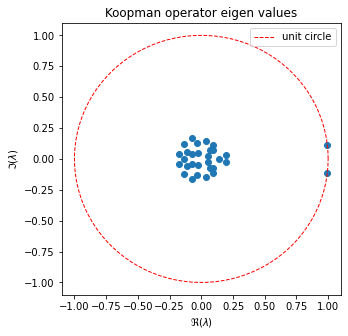

In [17]:
plt.figure(figsize=(5, 5))
plot_eigenvalues(KPM)

One can observe that the eigen values remain in the unit circle, so the Koopman operator is stable.

In [18]:
N = 30
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
xv, yv = np.meshgrid(x, y)

Flow = np.zeros((N,N,2))

for i in range(N):
    for j in range(N):
        Flow[i,j,:] = duffing(0,np.array([xv[i,j],yv[i,j]]))

AUTOENCODER.eval() 
KPM.eval()
Flow_pred = np.zeros((N,N,2))
for i in range(N):
    for j in range(N):
        Flow_pred[i,j,:] = (AUTOENCODER.decoder(
                            torch.matmul(
                            AUTOENCODER.encoder(torch.from_numpy(np.array([[xv[i,j],yv[i,j]]])).to(device)), Koop.weight.t())
                            ).detach().cpu().numpy() - [[xv[i,j],yv[i,j]]]).ravel()/(tmax/niter)
        

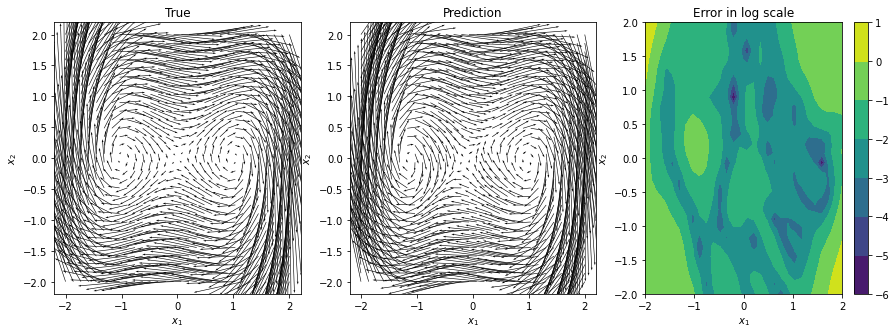

In [19]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.quiver(xv,yv, Flow[:,:,0], Flow[:,:,1], scale=10)
ax.set_title('True')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(132)
ax.quiver(xv,yv, Flow_pred[:,:,0], Flow_pred[:,:,1], scale=10)
ax.set_title('Prediction')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(133)
cp = ax.contourf(xv, yv, np.log(np.linalg.norm(Flow - Flow_pred, axis=2)))
fig.colorbar(cp)
ax.set_title('Error in log scale')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

### Continuous in time case

Considering $x_r$ as the observation of a state at time $t$, and $x_{r+1}$ the state at time $t+ \Delta t$, for $\Delta t \rightarrow 0$  it is also possible to define the continuous-time infinitesimal generator of the Koopman operator family as

$$
\mathcal{L} g (x_t)  = \lim_{\Delta t \rightarrow 0} \frac{\mathcal{K}g(x_t)- g(x_{t})}{\Delta t} = \frac{g \circ\mathbf{F} (x_t) -x_t}{\Delta t}
$$

The pevious expression defines the Lie derivative, and for this reason $\mathcal{L}$ is known as the Lie operator. $\mathcal{L}$ describes the continuous dynamics of the observables in the Koopman space:

$$
\dot{g} (x) = \mathcal{L} g(x).
$$

The latter can be further expressed as:

$$
\dot{g} (x(t)) = \frac{dg(x)}{dt} = \nabla_x g \frac{dx}{dt} = \nabla_x g \cdot f(x) =\mathcal{L} g(x).
$$

Given $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{L}_{\phi}$ three parameterized functions, the following conditions hold:

1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x)) - x  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{L_{\phi}} g_{\theta} ( x ) - \nabla g_{\theta} \cdot f(x)  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{L_{\phi}} g_{\theta} ( x )\right) - f(x) \Vert = 0
     $$

As long as the system $f(x)$ is known, the three errors can be computed without data belonging to trajectories. 

In [20]:
# create dataset for continuous Koopman 
# with the same amount of points of the Discontinuous Koopman case
X0 = (np.random.rand(Ninit*(niter-1),2)-0.5)*4 
dX =np.zeros(X0.shape)
for i in tqdm(range(X0.shape[0])):
    dX[i,:] = duffing(0,X0[i,:])

100%|██████████| 299940/299940 [00:00<00:00, 391837.92it/s]


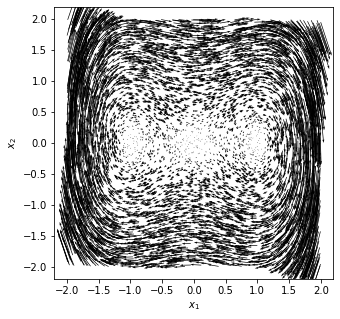

In [21]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.quiver(X0[::50,0],X0[::50,1], dX[::50,0]*0.2, dX[::50,1]*0.2, scale=10)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

In [22]:
# create the models
feature_dim = 2       # dimension of the Duffing oscillator
hidden_layer = 5      # number of hidden layers in g (ENCODER) and \varphi (DECODER) 
output_dim = 30       # dimension in Koopman space
batch_size = 2000     # data per batch

In [23]:
X_train, X_test, Y_train, Y_test =  train_test_split(X0, dX, test_size=0.2)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

training_data = TensorDataset(torch.from_numpy(X_train),torch.from_numpy(Y_train))
test_data = TensorDataset(torch.from_numpy(X_test),torch.from_numpy(Y_test))

train_dataloader_continuous = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader_continuous = DataLoader(test_data, batch_size=batch_size, shuffle=True)

(239952, 2) (59988, 2) (239952, 2) (59988, 2)


In [24]:
class encoder(nn.Module):
    def __init__(self, layer_dim):
        super(encoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i+1]))
        
    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)

In [25]:
class decoder(nn.Module):
    def __init__(self, layer_dim):
        super(decoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1,0,-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i-1]))
        
    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)

In [26]:
class autoencoder(nn.Module):
    def __init__(self,feature_dim, hidden_layer, output_dim):
        super(autoencoder, self).__init__()
        layer_dim = [output_dim if i == hidden_layer else feature_dim+i*(output_dim-feature_dim)//hidden_layer for i in range(hidden_layer+1)]
        self.encoder = encoder(layer_dim)
        self.decoder = decoder(layer_dim)
    def forward(self, X):
        X = self.encoder(X)
        return self.decoder(X)

The Lie operator must be defined such that it will be always stable by construction.
To do that, we consider a matrix of parameters $\Psi \in \mathbb{R}^{m \times m}$ and a vector of parameters $\Gamma \in \mathbb{R}^m$. The resulting Lie operator will be of the form:

$$
\mathbf{L} = (\Psi - \Psi^T) - \text{diag}(\vert \Gamma \vert)
$$

with eigenvalues whose real part $\Re(\lambda) \leq 0$ .
See https://math.stackexchange.com/questions/952233/eigenvalues-of-the-sum-of-a-diagonal-matrix-and-a-skew-symmetric-matrix for the mathematical proof. Moreover if $\lambda \in \mathbb{C}$ is an eigenvalue of $\mathbf{L}$, it turns out that its real part $\Re(\lambda) \propto \Vert \Gamma \Vert$, i.e. it only depends on $\Gamma$. Minimizing the $\Vert \cdot \Vert_{\infty}$ norm, we can force just a few modes to be on the $\Re(\lambda) =0$ axes.



**Question 4.** : As you did for the discrete case, you now have to implement the `LieModule` module. It should have the form indicated above to guarantee $\Re(\lambda) \leq 0$.

In [27]:
# custom nn.Linear to recover the Lie operator
class LieModule(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim
        self.weight = torch.nn.Parameter(torch.randn(output_dim, output_dim))
        self.reset_parameters()
        self.diagonal = torch.nn.Parameter(
            torch.diag(torch.abs(torch.randn(output_dim)))
            )
        self.weight = torch.nn.Parameter(
            (self.weight - self.weight.T) - self.diagonal
        )

        self.layer = nn.Linear(output_dim, output_dim, bias=False)
        with torch.no_grad():
              self.layer.weight = self.weight
        
    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))

    def forward(self, X):
        x, y = X.shape
        if x != self.output_dim and y != self.output_dim:
            sys.exit(f'Wrong Input Features. Please use tensor with {self.output_dim} Input Features')
        return self.layer(X), self.layer

In [28]:
# start training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [29]:
AUTOENCODER = autoencoder(feature_dim, hidden_layer, output_dim).to(device)
LIE = LieModule(output_dim).to(device)
print(AUTOENCODER)

autoencoder(
  (encoder): encoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=2, out_features=7, bias=True)
      (1): Linear(in_features=7, out_features=13, bias=True)
      (2): Linear(in_features=13, out_features=18, bias=True)
      (3): Linear(in_features=18, out_features=24, bias=True)
      (4): Linear(in_features=24, out_features=30, bias=True)
    )
  )
  (decoder): decoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=30, out_features=24, bias=True)
      (1): Linear(in_features=24, out_features=18, bias=True)
      (2): Linear(in_features=18, out_features=13, bias=True)
      (3): Linear(in_features=13, out_features=7, bias=True)
      (4): Linear(in_features=7, out_features=2, bias=True)
    )
  )
)


Some tricks are needed to train. If the autoencoder and the Lie model are learned at the same speed, the training turns out to be highly unstable since the three loss functions have moving targets. For this reason, the Lie learning rate has been chosen smaller than the autoencoder one.

In [30]:
opt_aut = torch.optim.Adam(AUTOENCODER.parameters(), lr=0.0001, weight_decay=1e-3)
opt_lie = torch.optim.Adam(LIE.parameters(), lr=0.00001, weight_decay=1e-3)

A further loss is considered to stabilize the learning stage. The state $x$ belongs to a compact set, since it is the solution of a dissipative dynamical system. This is not true for $g(x)$ (we need to choose appropriate activation functions to have appropriate Liptchitz guarantees). To avoid discrepancies in magnitudes of $g_i(x)$, a regularization loss is added:

$$
\mu = \frac{1}{m} \sum_m g_i(x) = 0  \quad \text{and} \quad  \sigma = \left( \frac{1}{m}\sum_m(g_i(x)-\mu)^2 \right)^{1/2} = 1
$$

inspired by VAE.

For the training to be smooth, the encoder parameters are not affected by the **prediction loss in phase space**. This is based on an empirical observation and is motivated by the fact that the encoder appears in the three losses and plays a competitive role against the decoder and the Lie model. This should not affect the results since the encoder remains coupled with the decoder in the **reconstruction loss** and with the Lie operator in the **prediction loss in Koopman space**.

**Question 5.** : Implement the loss function similarly to what you did for the **Question 2.**

In [31]:
def LOSS(X_, dX, gX, dgX, X_recon, dX_recon, jvp,
         reconstruction_factor = 1.0, koopman_factor = 1.0, phase_factor = 1.0,
        ):
    # To be Implemented
    criterion = nn.MSELoss()
    reconstruction_error = criterion(X_, X_recon) * reconstruction_factor
    error_koopman_space = criterion(dgX, jvp) * koopman_factor
    total_loss = reconstruction_error + error_koopman_space

    # As mentionned above, for the training to be smooth,
    # the encoder parameters are not affected by the prediction loss in phase space
    for p in AUTOENCODER.encoder.parameters():
      p.requires_grad = False
    error_phase_space = criterion(dX_recon, dX) * phase_factor
    for p in AUTOENCODER.encoder.parameters():
      p.requires_grad = True
    total_loss += error_phase_space

    mean = torch.mean(gX, dim=0)
    std = torch.sqrt(torch.mean((gX - mean)**2, dim=0))
    total_loss += criterion(mean, torch.zeros(mean.shape, device=device))
    total_loss += criterion(std, torch.ones(mean.shape, device=device)) 

    return total_loss

Since trajectories are not needed, random states can be sampled from the system manifold $x_1 \in [-2, 2]$, $x_2 \in [-2, 2]$ (see previous figure).

In [32]:
for epoch in range(100):
    AUTOENCODER.train() 
    LIE.train()
    total_train_loss = 0
    total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
    for X_, dX_ in train_dataloader_continuous:
        X_, dX_ = X_.to(device), dX_.to(device)

        opt_aut.zero_grad()
        opt_lie.zero_grad()
         
        # dgX = LIE*gX 
        # jvp = \nabla g * f(X_)
        (gX, jvp) = autograd.functional.jvp(AUTOENCODER.encoder,X_,dX_, create_graph=True)
        X_recon = AUTOENCODER.decoder(gX)
         
        dgX, L = LIE(gX)
        dX_recon = AUTOENCODER.decoder(dgX)
            
        output = LOSS(X_, dX_, gX, dgX, X_recon, dX_recon, jvp)
        output.backward()
        opt_aut.step()
        opt_lie.step()
        
        if epoch%1 == 0:
            total_train_loss += output.item()/X_.size(0)/len(train_dataloader_continuous)
    if epoch%1 == 0:    
        
        print(epoch, total_train_loss)
    
    if epoch%10 == 0:
        AUTOENCODER.eval() 
        LIE.eval()
        with torch.no_grad():
            total_test_loss = 0
            total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0   
            for X_, dX_ in test_dataloader_continuous:
                X_, dX_ = X_.to(device), dX_.to(device)
    
                (gX, jvp) = autograd.functional.jvp(AUTOENCODER.encoder,X_,dX_, create_graph=True)
                X_recon = AUTOENCODER.decoder(gX)
         
                dgX, L = LIE(gX)
                dX_recon = AUTOENCODER.decoder(dgX)
            
                output = LOSS(X_, dX_, gX, dgX, X_recon, dX_recon, jvp)
                total_test_loss += output.item()/X_.size(0)/len(test_dataloader_continuous)
            print('-'*50, 'TEST', '-'*50)
            print(epoch, total_test_loss)
            print('-'*106)
            

0 0.0024843854364735127
-------------------------------------------------- TEST --------------------------------------------------
0 0.0024284729787994856
----------------------------------------------------------------------------------------------------------
1 0.0023043282368638263
2 0.001981121600291832
3 0.0017809943451023416
4 0.0015267678231952878
5 0.0011545757568125555
6 0.0009396422678950228
7 0.0008553910336823075
8 0.0008172355867294619
9 0.0007881984238726565
10 0.0007593676942325159
-------------------------------------------------- TEST --------------------------------------------------
10 0.0007392595637772371
----------------------------------------------------------------------------------------------------------
11 0.0007243186932963091
12 0.0006683627981998006
13 0.0005548658553896963
14 0.0004212692918029999
15 0.00036021039251653823
16 0.0003277887283345871
17 0.0003049968250507077
18 0.00028691377462767133
19 0.00027157864333146917
20 0.00025803492150353003
-----

### Verification

**Question 6.** : As in the **Question 3.** we want to ensure the Lie operator is stable. This can be verified by checking that the real part of the eigenvalues is negative. Plot the relevant eigenvalues of the Lie operator. You can use the [`numpy.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to retrieve the eigenvalues of a matrix.

In [33]:
#check LIE stability

def plot_eigenvalues_lie_operator(lie_operator):
  Lambda , _ = np.linalg.eig(lie_operator.weight.detach().cpu().numpy()) 
  plt.plot(np.imag(Lambda),np.real(Lambda), 'o')
  lim = max(np.imag(Lambda))*1.2
  dummy = np.arange(-lim,lim,lim*0.1)
  plt.plot(dummy, dummy*0,'--')
  plt.xlabel('$\Im(\lambda)$')
  plt.ylabel('$\Re(\lambda)$')

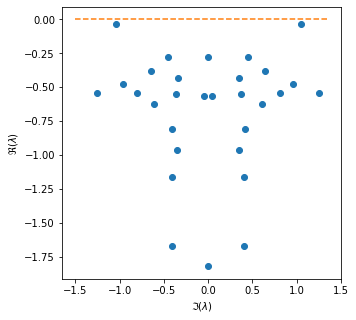

In [34]:
plt.figure(figsize=(5, 5))
plot_eigenvalues_lie_operator(L)

In [35]:
def DUFFING(x : np.ndarray) -> np.ndarray:
    dx = np.zeros(x.shape)
    dx[0] = x[1]
    dx[1] = x[0] -x[0]**3 
    return dx

N = 30
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
xv, yv = np.meshgrid(x, y)

Flow = np.zeros((N,N,2))

for i in range(N):
    for j in range(N):
        Flow[i,j,:] = DUFFING(np.array([xv[i,j],yv[i,j]]))

AUTOENCODER.eval() 
LIE.eval()
Flow_pred = np.zeros((N,N,2))
for i in range(N):
    for j in range(N):
        Flow_pred[i,j,:] =  AUTOENCODER.decoder(
                            torch.matmul(
                            AUTOENCODER.encoder(torch.from_numpy(np.array([[xv[i,j],yv[i,j]]])).to(device)), L.weight.t())
                            ).detach().cpu().numpy()


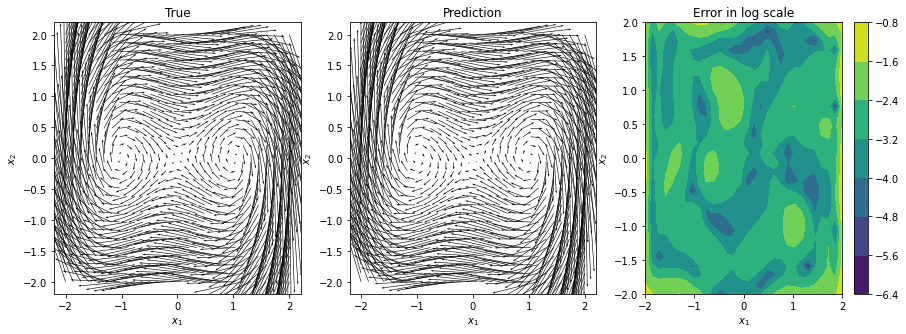

In [36]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.quiver(xv,yv, Flow[:,:,0], Flow[:,:,1], scale=10)
ax.set_title('True')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(132)
ax.quiver(xv,yv, Flow_pred[:,:,0], Flow_pred[:,:,1], scale=10)
ax.set_title('Prediction')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(133)
cp = ax.contourf(xv, yv, np.log(np.linalg.norm(Flow - Flow_pred, axis=2)))
fig.colorbar(cp)
ax.set_title('Error in log scale')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()

**Question 7.** : Compare and comment below the two approaches.

## a. Experiment code

Before digging into the comparisons, let's encapsulate some portion of the code defined above in order to make some parameters' change easily

In [37]:
class DiscreteKoopman:
  def __init__(self, parameters):
    self.reconstruction_factor = parameters["reconstruction_factor"]
    self.koopman_factor = parameters["koopman_factor"]
    self.phase_factor = parameters["phase_factor"]
    self.use_divergence_to_normal = parameters["use_divergence_to_normal"]
    self.frozen_encoder = parameters["frozen_encoder"]
    self.n_epochs = parameters["n_epochs"]

    self.AUTOENCODER = autoencoder(feature_dim, hidden_layer, output_dim).to(device)
    self.KPM = KoopmanModule(output_dim, ortho_init=parameters["ortho_init"]).to(device)

  def loss(self, X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred):
    criterion = nn.MSELoss()
    reconstruction_error = criterion(X_, X_recon) * self.reconstruction_factor
    error_phase_space = criterion(Y_, Y_pred) * self.phase_factor
    if not self.frozen_encoder:
      error_koopman_space = criterion(gY_pred, gY_) * self.koopman_factor
      total_loss = reconstruction_error + error_koopman_space + error_phase_space
    else:
      total_loss = reconstruction_error + error_phase_space

    if self.use_divergence_to_normal:
      mean = torch.mean(gX_, dim=0)
      std = torch.sqrt(torch.mean((gX_ - mean)**2, dim=0))
      total_loss += criterion(mean, torch.zeros(mean.shape, device=device))
      total_loss += criterion(std, torch.ones(mean.shape, device=device))

    return total_loss

  def train(self, train_dataloader, test_dataloader):
    opt_aut = torch.optim.Adam(self.AUTOENCODER.parameters(), lr=0.0001)
    opt_kpm = torch.optim.Adam(self.KPM.parameters(), lr=0.00001)
    train_losses = []
    for epoch in range(self.n_epochs):
      self.AUTOENCODER.train() 
      self.KPM.train()
      total_train_loss = 0
      total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
      for X_, Y_ in train_dataloader:
          X_, Y_ = X_.to(device), Y_.to(device)
          
          opt_aut.zero_grad()
          opt_kpm.zero_grad()
          
          gX_ = self.AUTOENCODER.encoder(X_)
          gY_ = self.AUTOENCODER.encoder(Y_)
          X_recon = self.AUTOENCODER.decoder(gX_)
          gY_pred, Koop = self.KPM(gX_)
          Y_pred = self.AUTOENCODER.decoder(gY_pred)  

          ##### Main difference with previous function: freezing of the encoder gradient #####

          if self.frozen_encoder:
            for p in self.AUTOENCODER.encoder.parameters():
              p.requires_grad = False
            loss_l = nn.MSELoss()(gY_pred, gY_) * self.koopman_factor
            for p in AUTOENCODER.encoder.parameters():
              p.requires_grad = True
            output = self.loss(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred) + loss_l

          else:
            output = self.loss(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred)
          output.backward()
          opt_aut.step()
          opt_kpm.step()
      
          if epoch%1 == 0:
              total_train_loss += output.item()/X_.size(0)/len(train_dataloader)
      train_losses.append(total_train_loss)
      
      if epoch%10 == 0:
          self.AUTOENCODER.eval() 
          self.KPM.eval()
          with torch.no_grad():
              total_test_loss = 0  
              for X_, Y_ in test_dataloader:
                  X_, Y_ = X_.to(device), Y_.to(device)
      
                  gX_ = self.AUTOENCODER.encoder(X_)
                  gY_ = self.AUTOENCODER.encoder(Y_)
                  X_recon = self.AUTOENCODER.decoder(gX_) # gX_ ? 
                  gY_pred, Koop = self.KPM(gX_)
                  Y_pred = self.AUTOENCODER.decoder(gY_pred)   
                      
                  output = self.loss(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred)
              total_test_loss += output.item()/X_.size(0)/len(test_dataloader)
    return train_losses

In [38]:
class ContinuousKoopman:
  def __init__(self, parameters):
    self.reconstruction_factor = parameters["reconstruction_factor"]
    self.koopman_factor = parameters["koopman_factor"]
    self.phase_factor = parameters["phase_factor"]
    self.n_epochs = parameters["n_epochs"]
    self.frozen_encoder = parameters["frozen_encoder"]
    self.use_divergence_to_normal = parameters["use_divergence_to_normal"]

    self.AUTOENCODER = autoencoder(feature_dim, hidden_layer, output_dim).to(device)
    self.LIE = LieModule(output_dim).to(device)

  def loss(self, X_, dX, gX, dgX, X_recon, dX_recon, jvp):
    criterion = nn.MSELoss()
    reconstruction_error = criterion(X_, X_recon) * self.reconstruction_factor
    error_koopman_space = criterion(dgX, jvp) * self.koopman_factor
    total_loss = reconstruction_error + error_koopman_space

    if self.frozen_encoder:
      # As mentionned above, for the training to be smooth,
      # the encoder parameters are not affected by the prediction loss in phase space
      for p in AUTOENCODER.encoder.parameters():
        p.requires_grad = False
      error_phase_space = criterion(dX_recon, dX) * self.phase_factor
      for p in AUTOENCODER.encoder.parameters():
        p.requires_grad = True
      total_loss += error_phase_space
    else:
      total_loss += criterion(dX_recon, dX) * self.phase_factor

    if self.use_divergence_to_normal:
      mean = torch.mean(gX, dim=0)
      std = torch.sqrt(torch.mean((gX - mean)**2, dim=0))
      total_loss += criterion(mean, torch.zeros(mean.shape, device=device))
      total_loss += criterion(std, torch.ones(mean.shape, device=device))

    return total_loss

  def train(self, train_dataloader, test_dataloader):
    opt_aut = torch.optim.Adam(self.AUTOENCODER.parameters(), lr=0.0001, weight_decay=1e-3)
    opt_lie = torch.optim.Adam(self.LIE.parameters(), lr=0.00001, weight_decay=1e-3)
    train_losses = []
    for epoch in range(self.n_epochs):
      self.AUTOENCODER.train() 
      self.LIE.train()
      total_train_loss = 0
      total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
      for X_, dX_ in train_dataloader:
          X_, dX_ = X_.to(device), dX_.to(device)

          opt_aut.zero_grad()
          opt_lie.zero_grad()
          
          # dgX = LIE*gX 
          # jvp = \nabla g * f(X_)
          (gX, jvp) = autograd.functional.jvp(self.AUTOENCODER.encoder,X_,dX_, create_graph=True)
          X_recon = self.AUTOENCODER.decoder(gX)
          
          dgX, L = self.LIE(gX)
          dX_recon = self.AUTOENCODER.decoder(dgX)
              
          output = self.loss(X_, dX_, gX, dgX, X_recon, dX_recon, jvp)
          output.backward()
          opt_aut.step()
          opt_lie.step()
          
          if epoch%1 == 0:
              total_train_loss += output.item()/X_.size(0)/len(train_dataloader)
      train_losses.append(total_train_loss)
      
      if epoch%10 == 0:
          self.AUTOENCODER.eval() 
          self.LIE.eval()
          with torch.no_grad():
              total_test_loss = 0
              total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0   
              for X_, dX_ in test_dataloader:
                  X_, dX_ = X_.to(device), dX_.to(device)
      
                  (gX, jvp) = autograd.functional.jvp(self.AUTOENCODER.encoder,X_,dX_, create_graph=True)
                  X_recon = self.AUTOENCODER.decoder(gX)
          
                  dgX, L = self.LIE(gX)
                  dX_recon = self.AUTOENCODER.decoder(dgX)
              
                  output = self.loss(X_, dX_, gX, dgX, X_recon, dX_recon, jvp)
                  total_test_loss += output.item()/X_.size(0)/len(test_dataloader)
    return train_losses

## b. Stability of the operators

First, let's summarize the stability of the two operators (discrete Koopman and Lie operator). For the discrete case, we will consider both orthogonal initiatization and manual initialization using Perron-Frobenius theorem.


In [39]:
parameters = {
    "reconstruction_factor": 1.0,
    "koopman_factor": 1.0,
    "phase_factor": 1.0,
    "use_divergence_to_normal": True,
    "frozen_encoder": False,
    "n_epochs": 10,
    "ortho_init": False,
}

discrete_koopman = DiscreteKoopman(parameters)
_ = discrete_koopman.train(train_dataloader_discrete, test_dataloader_discrete)

parameters["ortho_init"] = True

discrete_koopman_ortho = DiscreteKoopman(parameters)
_ = discrete_koopman_ortho.train(train_dataloader_discrete, test_dataloader_discrete)


parameters_continuous = {
    "reconstruction_factor": 1.0,
    "koopman_factor": 1.0,
    "phase_factor": 1.0,
    "n_epochs": 10,
    "use_divergence_to_normal": True,
    "frozen_encoder": True,
}

continuous_koopman = ContinuousKoopman(parameters_continuous)
_ = continuous_koopman.train(train_dataloader_continuous, test_dataloader_continuous)

Text(0.5, 1.0, 'Continuous Koopman operator eigenvalues')

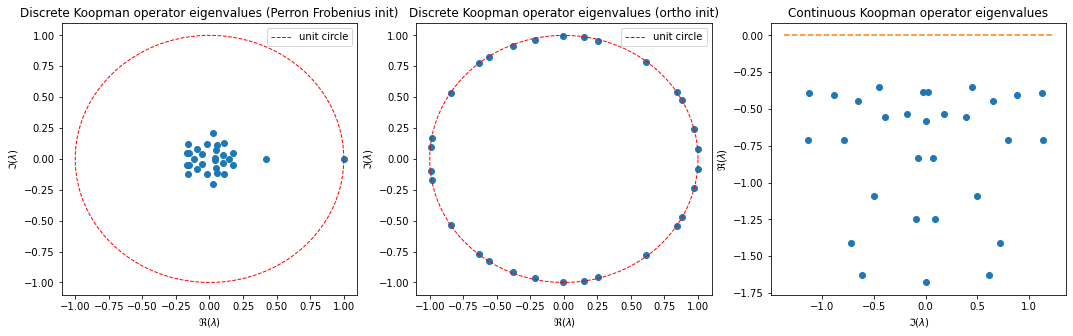

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

plt.subplot(1, 3, 1)
plot_eigenvalues(discrete_koopman.KPM)
plt.title("Discrete Koopman operator eigenvalues (Perron Frobenius init)")

plt.subplot(1, 3, 2)
plot_eigenvalues(discrete_koopman_ortho.KPM)
plt.title("Discrete Koopman operator eigenvalues (ortho init)")

plt.subplot(1, 3, 3)
plot_eigenvalues_lie_operator(continuous_koopman.LIE)
plt.title("Continuous Koopman operator eigenvalues")

Once can observe that in the case of the discrete Koopman operator, the eigenvalues stay in the unit circle (even stricly for the majority of them using the Peron-Frobenius initialization ; while eigenvalues remain almost exactly on the circle when using orthogonal initialization). In the case of the continuous Koopman operator (Lie operator), the Real part of the eigenvalues is strickly negative. So in both case, we have stability.

## c. Influence of loss factors (discrete case)

Let's now have a look at the effect of changing the factors in the loss

In [41]:
parameters = {
    "reconstruction_factor": 2.0,
    "koopman_factor": 1.0,
    "phase_factor": 1.0,
    "use_divergence_to_normal": True,
    "frozen_encoder": False,
    "n_epochs": 100,
    "ortho_init": False,
}

discrete_koopman_reconstruction = DiscreteKoopman(parameters)
loss_reconstruction = discrete_koopman_reconstruction.train(train_dataloader_discrete, test_dataloader_discrete)

parameters["reconstruction_factor"] = 1.0
parameters["koopman_factor"] = 2.0

discrete_koopman_error_koopman = DiscreteKoopman(parameters)
loss_koopman = discrete_koopman_error_koopman.train(train_dataloader_discrete, test_dataloader_discrete)

parameters["koopman_factor"] = 1.0
parameters["phase_factor"] = 2.0

discrete_koopman_error_phase = DiscreteKoopman(parameters)
loss_phase = discrete_koopman_error_phase.train(train_dataloader_discrete, test_dataloader_discrete)

In [42]:
def plot_discrete_result(model):
  N = 30
  x = np.linspace(-2, 2, N)
  y = np.linspace(-2, 2, N)
  xv, yv = np.meshgrid(x, y)

  Flow = np.zeros((N,N,2))

  for i in range(N):
      for j in range(N):
          Flow[i,j,:] = duffing(0,np.array([xv[i,j],yv[i,j]]))

  model.AUTOENCODER.eval() 
  model.KPM.eval()
  Flow_pred = np.zeros((N,N,2))
  for i in range(N):
      for j in range(N):
          Flow_pred[i,j,:] = (model.AUTOENCODER.decoder(
                              torch.matmul(
                              model.AUTOENCODER.encoder(torch.from_numpy(np.array([[xv[i,j],yv[i,j]]])).to(device)), model.KPM.layer.weight.t())
                              ).detach().cpu().numpy() - [[xv[i,j],yv[i,j]]]).ravel()/(tmax/niter)

  fig = plt.figure(figsize=(15,5))
  ax = fig.add_subplot(131)
  ax.quiver(xv,yv, Flow[:,:,0], Flow[:,:,1], scale=10)
  ax.set_title('True')
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')

  ax = fig.add_subplot(132)
  ax.quiver(xv,yv, Flow_pred[:,:,0], Flow_pred[:,:,1], scale=10)
  ax.set_title('Prediction')
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')

  ax = fig.add_subplot(133)
  cp = ax.contourf(xv, yv, np.log(np.linalg.norm(Flow - Flow_pred, axis=2)))
  fig.colorbar(cp)
  ax.set_title('Error in log scale')
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')
  plt.show()


def plot_continuous_results(model):
  N = 30
  x = np.linspace(-2, 2, N)
  y = np.linspace(-2, 2, N)
  xv, yv = np.meshgrid(x, y)

  Flow = np.zeros((N,N,2))

  for i in range(N):
      for j in range(N):
          Flow[i,j,:] = DUFFING(np.array([xv[i,j],yv[i,j]]))

  model.AUTOENCODER.eval() 
  model.LIE.eval()
  Flow_pred = np.zeros((N,N,2))
  for i in range(N):
      for j in range(N):
          Flow_pred[i,j,:] =  model.AUTOENCODER.decoder(
                              torch.matmul(
                              model.AUTOENCODER.encoder(torch.from_numpy(np.array([[xv[i,j],yv[i,j]]])).to(device)), model.LIE.weight.t())
                              ).detach().cpu().numpy()
  fig = plt.figure(figsize=(15,5))
  ax = fig.add_subplot(131)
  ax.quiver(xv,yv, Flow[:,:,0], Flow[:,:,1], scale=10)
  ax.set_title('True')
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')

  ax = fig.add_subplot(132)
  ax.quiver(xv,yv, Flow_pred[:,:,0], Flow_pred[:,:,1], scale=10)
  ax.set_title('Prediction')
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')

  ax = fig.add_subplot(133)
  cp = ax.contourf(xv, yv, np.log(np.linalg.norm(Flow - Flow_pred, axis=2)))
  fig.colorbar(cp)
  ax.set_title('Error in log scale')
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')

  plt.show()

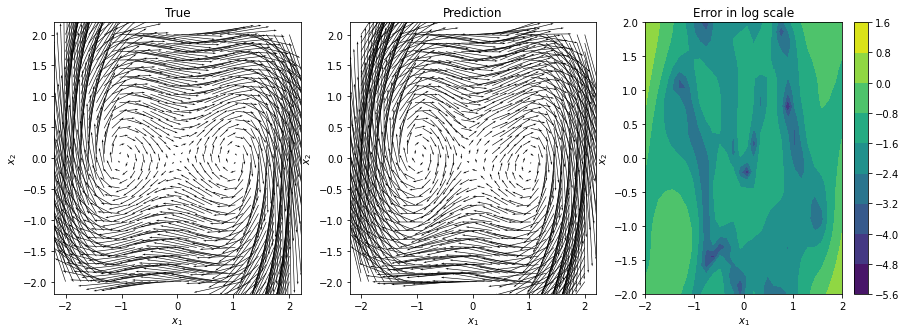

In [43]:
# Reconstruction factor = 2.0

plot_discrete_result(discrete_koopman_reconstruction)

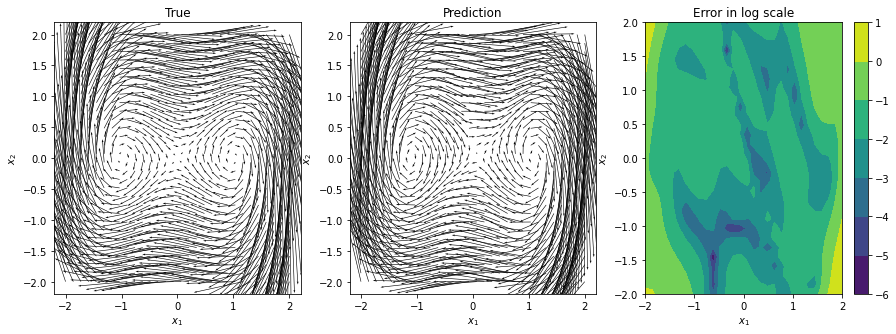

In [44]:
# Koopman space error factor = 2.0

plot_discrete_result(discrete_koopman_error_koopman)

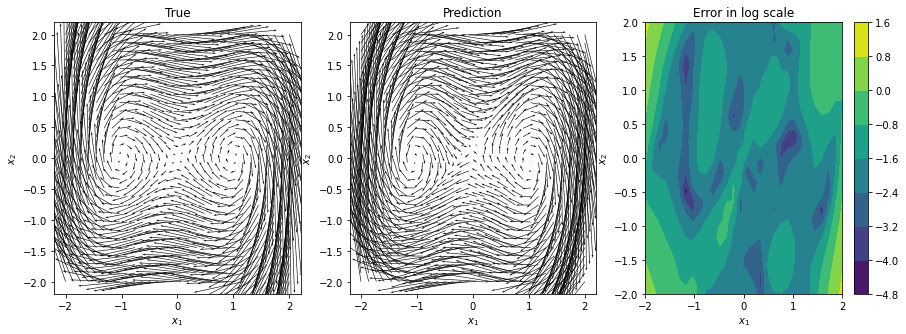

In [45]:
# Phase error factor = 2.0

plot_discrete_result(discrete_koopman_error_phase)

Text(0, 0.5, 'Training loss')

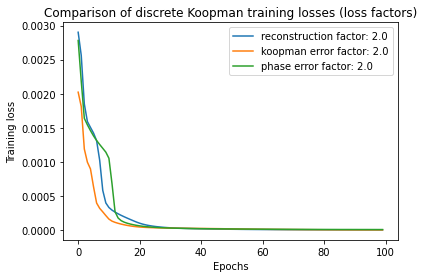

In [46]:
plt.plot(loss_reconstruction, label="reconstruction factor: 2.0")
plt.plot(loss_koopman, label="koopman error factor: 2.0")
plt.plot(loss_phase, label="phase error factor: 2.0")

plt.legend()
plt.title("Comparison of discrete Koopman training losses (loss factors)")
plt.xlabel("Epochs")
plt.ylabel("Training loss")

We can observe that varying the coefficient of the different errors in the loss can help smoothing and / or accelerating the training, which is for example the case for the koopman space error. However, all models did convergence to roughly the same solution.

## d. Influence of variations in the loss 

We then look at the effect of different modification on the loss: freezing the encoder gradients and enforcing the distrubtion in the Koopman space to be a stnadard normal distribution.

In [47]:
parameters = {
    "reconstruction_factor": 1.0,
    "koopman_factor": 1.0,
    "phase_factor": 1.0,
    "use_divergence_to_normal": False,
    "frozen_encoder": False,
    "n_epochs": 100,
    "ortho_init": False,
}

discrete_koopman = DiscreteKoopman(parameters)
loss = discrete_koopman.train(train_dataloader_discrete, test_dataloader_discrete)

parameters["use_divergence_to_normal"] = True

discrete_koopman_normal = DiscreteKoopman(parameters)
loss_normal = discrete_koopman_normal.train(train_dataloader_discrete, test_dataloader_discrete)

parameters["frozen_encoder"] = True
parameters["use_divergence_to_normal"] = False

discrete_koopman_frozen = DiscreteKoopman(parameters)
loss_frozen = discrete_koopman_frozen.train(train_dataloader_discrete, test_dataloader_discrete)

Text(0, 0.5, 'Training loss')

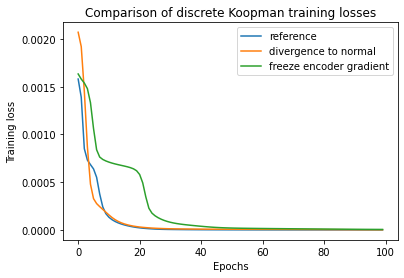

In [48]:
plt.plot(loss, label="reference")
plt.plot(loss_normal, label="divergence to normal")
plt.plot(loss_frozen, label="freeze encoder gradient")

plt.legend()
plt.title("Comparison of discrete Koopman training losses")
plt.xlabel("Epochs")
plt.ylabel("Training loss")

One can observe that adding a "regularization" method as enforcing the latent space to be close to a standard normal distrubiton (like in an VAE for example) makes the training smoother. The smoothing is also obtained by freezing the encoder gradients while computing the loss (the "step" that is less sharp on the training loss curve is smoother than without this freezing), even if in this case, it makes the training much slower.

Let's do the same experiment for the continuous operator (this time by progressively removing the regularizations).

In [49]:
parameters_continuous = {
    "reconstruction_factor": 1.0,
    "koopman_factor": 1.0,
    "phase_factor": 1.0,
    "n_epochs": 100,
    "use_divergence_to_normal": True,
    "frozen_encoder": True,
}

continuous_koopman = ContinuousKoopman(parameters_continuous)
loss = continuous_koopman.train(train_dataloader_continuous, test_dataloader_continuous)

parameters_continuous["frozen_encoder"] = False

continuous_koopman_no_freezing = ContinuousKoopman(parameters_continuous)
loss_no_freezing = continuous_koopman_no_freezing.train(train_dataloader_continuous, test_dataloader_continuous)

parameters_continuous["frozen_encoder"] = True
parameters_continuous["use_divergence_to_normal"] = False

continuous_koopman_no_normal = ContinuousKoopman(parameters_continuous)
loss_no_normal = continuous_koopman_no_normal.train(train_dataloader_continuous, test_dataloader_continuous)

parameters_continuous["frozen_encoder"] = False
parameters_continuous["use_divergence_to_normal"] = False

continuous_koopman_no_reg = ContinuousKoopman(parameters_continuous)
loss_no_reg = continuous_koopman_no_reg.train(train_dataloader_continuous, test_dataloader_continuous)

Text(0, 0.5, 'Training loss')

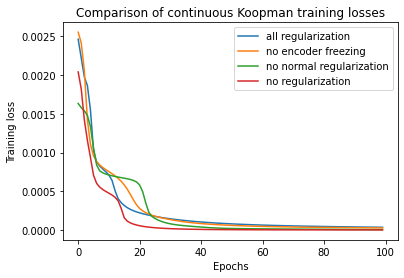

In [50]:
plt.plot(loss, label="all regularization")
plt.plot(loss_no_freezing, label="no encoder freezing")
plt.plot(loss_frozen, label="no normal regularization")
plt.plot(loss_no_normal, label="no regularization")

plt.legend()
plt.title("Comparison of continuous Koopman training losses")
plt.xlabel("Epochs")
plt.ylabel("Training loss")

One can also observe that the regularization can help making the training smoother, with for example removing the normal regulization that leads to a "step" in the training loss, with however the same counterpart as before that regulization can make the training slower. 

## e. Final comparisons of the two models

In [51]:
parameters = {
    "reconstruction_factor": 1.0,
    "koopman_factor": 1.0,
    "phase_factor": 1.0,
    "use_divergence_to_normal": False,
    "frozen_encoder": False,
    "n_epochs": 100,
    "ortho_init": False,
}

discrete_koopman = DiscreteKoopman(parameters)
loss_discrete = discrete_koopman.train(train_dataloader_discrete, test_dataloader_discrete)

parameters_continuous = {
    "reconstruction_factor": 1.0,
    "koopman_factor": 1.0,
    "phase_factor": 1.0,
    "n_epochs": 100,
    "use_divergence_to_normal": True,
    "frozen_encoder": True,
}

continuous_koopman = ContinuousKoopman(parameters_continuous)
loss_continuous = continuous_koopman.train(train_dataloader_continuous, test_dataloader_continuous)

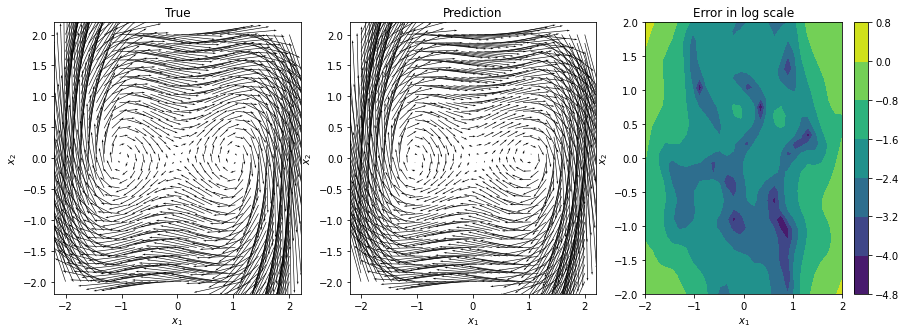

In [52]:
plot_discrete_result(discrete_koopman)

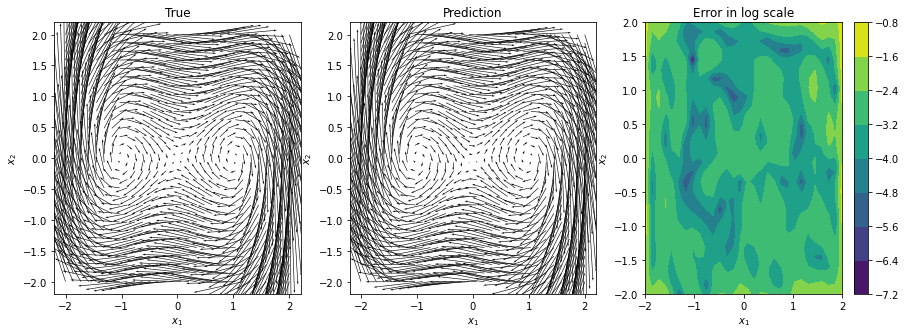

In [53]:
plot_continuous_results(continuous_koopman)

Text(0, 0.5, 'Training loss')

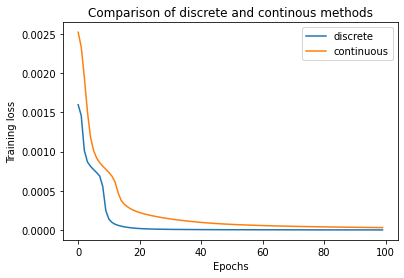

In [54]:
plt.plot(loss_discrete, label="discrete")
plt.plot(loss_continuous, label="continuous")

plt.legend()
plt.title("Comparison of discrete and continous methods")
plt.xlabel("Epochs")
plt.ylabel("Training loss")

To sum up, both approaches provide good predictions and are poweful methods to learn the dynamic of the Duffing system with neural networks, with often less errors in the discrete case as we can see above on the error map (which could be due to the fact that we use data from trajectories to train the discrete model). We have seen that both approaches (discrete and continuous) were stable (looking at the eigenvalues of their respective oeprators). The main difference of the continuous method compared to the discrete one is that we don't need datapoints to belong to trajectories to compute the errors and thus train the network (since we know the "flow term" $f(x)$). This continuous version has however some drawbacks, namely the care we need to have to train the neural network (different learning rates for the Lie module and the Autoencoder), and the need to use some regularization (forcing the latent space to be close to a normal distribution), even though we saw that these regulization techniques also apply to the discrete case in order to smooth the training.

Thanks for reading!
